# Store Sales - Time Series Forecasting

**Author:** Orlando Patricio Chacón Molina

**Fecha de creación:** 2022-03-02

**Fecha de actualización:** 2022-03-03

**Kaggle competition:** https://www.kaggle.com/c/store-sales-time-series-forecasting/overview

## Goal of the Competition
In this “getting started” competition, you’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

Specifically, you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores. You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

## Get Started
We highly recommend the Time Series course, which walks you through how to make your first submission. The lessons in this course are inspired by winning solutions from past Kaggle time series forecasting competitions.
Context
Forecasts aren’t just for meteorologists. Governments forecast economic growth. Scientists attempt to predict the future population. And businesses forecast product demand—a common task of professional data scientists. Forecasts are especially relevant to brick-and-mortar grocery stores, which must dance delicately with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time.

Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable product marketing.

## Potential Impact
If successful, you'll have flexed some new skills in a real world example. For grocery stores, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction. The results of this ongoing competition, over time, might even ensure your local store has exactly what you need the next time you shop.

## Read csv files, show DataFrames shapes and nans

In [ ]:
# Import Basic Libraries
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor


In [ ]:
# Read all datafiles
dataTrain   = pd.read_csv('data/train.csv')
dataTest   = pd.read_csv('data/test.csv')
dataHoliday = pd.read_csv('data/holidays_events.csv')
dataStores = pd.read_csv('data/stores.csv')
dataOil = pd.read_csv('data/oil.csv')


In [ ]:
dataTrainShape = dataTrain.shape
dataTrain.isna().mean()

In [ ]:
dataTestShape = dataTest.shape
dataTest.isna().mean()

In [ ]:
dataHolidayShape = dataHoliday.shape
dataHoliday.isna().mean()

In [ ]:
dataHoliday.head()

In [ ]:
dataHoliday.isna().mean()

In [ ]:
dataStoresShape = dataStores.shape

In [ ]:
dataStores.head()

In [ ]:
dataOilShape = dataOil.shape
dataOil.isna().mean()

## Merging and joining external data

### Insert column "sales" in dataTest
The column "sales", of the Test dataset, will be set to -1. This mechanism will allow us to later sepparate the Train and Test datasets.


In [ ]:
dataTestFilled = dataTest.copy()

try:
    dataTestFilled.insert(3,'sales',-1)
except:
    pass;

dataTestFilled.head()


### Train-Test (CSVs) concatenation
Both, Train and Test datasets will be concatenated to apply the same transformations. Later, the two datasets will be separated.

In [ ]:
# Show values and frequency
dataHoliday['locale'].value_counts()

In [ ]:
# DataFull will store the full data
# In the following line both, Train and Test datasets will be concatenated.
dataFull = pd.concat([dataTrain,dataTestFilled])
print (dataFull.shape)

# Add oil price from oil dataset (accoding to date).
dataFull = pd.merge(dataFull, dataOil,how='left',on='date')
print (dataFull.shape)

# Add and city and state from stores dataset (according to store_nbr)
dataFull = pd.merge(dataFull, dataStores[['store_nbr','city','state']],how='left',on='store_nbr')
print (dataFull.shape) 



# The following code will add cityHoliday, stateHoliday and nationalHoliday to the dataFull
# The external data source is holiday dataset. The data is binary encoded.

# City
dataFull = pd.merge(dataFull, dataHoliday[
    ['locale','locale_name','date']].groupby(['locale_name','date']).max().reset_index().rename(
        columns={'locale_name':'city','locale':'cityHoliday'}),how='left',on=['city','date'])
dataFull['cityHoliday'] = dataFull['cityHoliday'].map({'Local':1}).fillna(0).astype(int)
print (dataFull.shape) 

dataFull

# State
dataFull = pd.merge(dataFull, dataHoliday[
    ['locale','locale_name','date']].groupby(['locale_name','date']).max().reset_index().rename(
        columns={'locale_name':'state','locale':'stateHoliday'}),how='left',on=['state','date'])
dataFull['stateHoliday'] = dataFull['stateHoliday'].map({'Regional':1}).fillna(0).astype(int)
print (dataFull.shape)

# National
dataFull = pd.merge(dataFull, dataHoliday.loc[dataHoliday['locale']=='National',
        ['locale','date']].groupby(['date']).max().reset_index().rename(
            columns={'locale':'nationalHoliday'}),how='left',on=['date'])
dataFull['nationalHoliday'] = dataFull['nationalHoliday'].map({'National':1}).fillna(0).astype(int)
print (dataFull.shape)

dataFull.head()


### Oil price imputation using KNN
Only date variable is used to estimate the price. 

* n_neighbors is set to 1. Therefore, NaNs will adopt the value of closest(only one) neighbor, and non-NaNs won't change. 

In [ ]:
dataFull.loc[~dataFull['dcoilwtico'].isna(),['dcoilwtico']]

In [ ]:
knnClf = KNeighborsRegressor(n_neighbors=1,n_jobs=100)

knnClf.fit(dataFull.loc[~dataFull['dcoilwtico'].isna(),['date']]['date'].apply(lambda x: x.replace('-','')).astype(int).to_frame().dropna(),
    dataFull.loc[~dataFull['dcoilwtico'].isna(),['dcoilwtico']])

dataFull['dcoilwtico'] = knnClf.predict(dataFull['date'].apply(lambda x: x.replace('-','')).astype(int).to_frame())

### Save DataFull
Transformed dataset will be saved into 'data/data_full.csv'.

In [ ]:
dataFull.to_csv('data/data_full.csv')


## Analyze data from transformed dataset.

In order to avoid recalculation after reopening the notebook, the data will be stored in a csv file. Therefor, previous tasks won't requiere to be re-run (Run only one time) 

In [2]:
# Import basic libraries
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

In [3]:
dataTest   = pd.read_csv('data/test.csv')

dataFull = pd.read_csv('data/data_full.csv')
dataFull.drop(columns=['Unnamed: 0','Unnamed: 0.1','id'], inplace=True)


### OneHotEncoding 

In [4]:
categories = dataFull['family'].unique().tolist()
enc = OneHotEncoder()
encFeature = pd.DataFrame(enc.fit_transform(dataFull[['family']]).toarray()).astype(int)
encFeature.columns = categories
dataFull = dataFull.join(encFeature).drop(columns=['family'])
dataFull.head()

,date,store_nbr,sales,onpromotion,dcoilwtico,city,state,cityHoliday,stateHoliday,nationalHoliday,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
0,2013-01-01,1,0.0,0,93.14,Quito,Pichincha,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,1,0.0,0,93.14,Quito,Pichincha,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-01,1,0.0,0,93.14,Quito,Pichincha,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-01,1,0.0,0,93.14,Quito,Pichincha,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-01,1,0.0,0,93.14,Quito,Pichincha,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
categories = dataFull['city'].unique().tolist()
enc = OneHotEncoder()
encFeature = pd.DataFrame(enc.fit_transform(dataFull[['city']]).toarray()).astype(int)
encFeature.columns = categories
dataFull = dataFull.join(encFeature).drop(columns=['city'])
dataFull.head()


,date,store_nbr,sales,onpromotion,dcoilwtico,state,cityHoliday,stateHoliday,nationalHoliday,dcoilwtico_pred,...,Babahoyo,Quevedo,Playas,Libertad,Cuenca,Loja,Machala,Esmeraldas,Manta,El Carmen
0,2013-01-01,1,0.0,0,93.14,Pichincha,0,0,1,93.14,...,0,0,0,0,0,0,1,0,0,0
1,2013-01-01,1,0.0,0,93.14,Pichincha,0,0,1,93.14,...,0,0,0,0,0,0,1,0,0,0
2,2013-01-01,1,0.0,0,93.14,Pichincha,0,0,1,93.14,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-01,1,0.0,0,93.14,Pichincha,0,0,1,93.14,...,0,0,0,0,0,0,1,0,0,0
4,2013-01-01,1,0.0,0,93.14,Pichincha,0,0,1,93.14,...,0,0,0,0,0,0,1,0,0,0


In [6]:
categories = dataFull['state'].unique().tolist()
enc = OneHotEncoder()
encFeature = pd.DataFrame(enc.fit_transform(dataFull[['state']]).toarray()).astype(int)
encFeature.columns = map(lambda x: 'state_' + x, categories)
dataFull = dataFull.join(encFeature).drop(columns=['state'])
dataFull.head()

,date,store_nbr,sales,onpromotion,dcoilwtico,cityHoliday,stateHoliday,nationalHoliday,dcoilwtico_pred,AUTOMOTIVE,...,state_Pastaza,state_Tungurahua,state_Guayas,state_Santa Elena,state_Los Rios,state_Azuay,state_Loja,state_El Oro,state_Esmeraldas,state_Manabi
0,2013-01-01,1,0.0,0,93.14,0,0,1,93.14,1,...,0,0,0,0,0,0,1,0,0,0
1,2013-01-01,1,0.0,0,93.14,0,0,1,93.14,0,...,0,0,0,0,0,0,1,0,0,0
2,2013-01-01,1,0.0,0,93.14,0,0,1,93.14,0,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-01,1,0.0,0,93.14,0,0,1,93.14,0,...,0,0,0,0,0,0,1,0,0,0
4,2013-01-01,1,0.0,0,93.14,0,0,1,93.14,0,...,0,0,0,0,0,0,1,0,0,0


### Transform date column
Separate year, month and week day from the original date. Delete original column.

In [7]:
dataFull['date']
dataFull['date']= dataFull['date'].astype('datetime64')

dataFull['year'] = dataFull['date'].dt.year
dataFull['month'] = dataFull['date'].dt.month
dataFull['week_day'] = dataFull['date'].dt.dayofweek
dataFull.drop(columns=['date'],inplace=True)

In [8]:
isTest = dataFull['sales']==-1
X_train = dataFull.loc[~isTest, :].drop(columns=['sales'])
y_train = dataFull.loc[~isTest, 'sales']
X_test = dataFull.loc[isTest, :].drop(columns=['sales'])
X_train

,store_nbr,onpromotion,dcoilwtico,cityHoliday,stateHoliday,nationalHoliday,dcoilwtico_pred,AUTOMOTIVE,BABY CARE,BEAUTY,...,state_Santa Elena,state_Los Rios,state_Azuay,state_Loja,state_El Oro,state_Esmeraldas,state_Manabi,year,month,week_day
0,1,0,93.14,0,0,1,93.14,1,0,0,...,0,0,0,1,0,0,0,2013,1,1
1,1,0,93.14,0,0,1,93.14,0,1,0,...,0,0,0,1,0,0,0,2013,1,1
2,1,0,93.14,0,0,1,93.14,0,0,1,...,0,0,0,1,0,0,0,2013,1,1
3,1,0,93.14,0,0,1,93.14,0,0,0,...,0,0,0,1,0,0,0,2013,1,1
4,1,0,93.14,0,0,1,93.14,0,0,0,...,0,0,0,1,0,0,0,2013,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,0,47.57,0,0,0,47.57,0,0,0,...,0,0,0,1,0,0,0,2017,8,1
3000884,9,1,47.57,0,0,0,47.57,0,0,0,...,0,0,0,1,0,0,0,2017,8,1
3000885,9,148,47.57,0,0,0,47.57,0,0,0,...,0,0,0,1,0,0,0,2017,8,1
3000886,9,8,47.57,0,0,0,47.57,0,0,0,...,0,0,0,1,0,0,0,2017,8,1


In [18]:
#Import machine learining libraries (Most of them)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor

import matplotlib.pyplot as plt

import time

### Standard Scalation

In [10]:
scaler = StandardScaler()

scaledTrain = scaler.fit_transform(X_train)
scaledTest = scaler.fit_transform(X_test)

In [11]:
pca = PCA()
pca.fit(scaledTrain)

PCA()

Text(0, 0.5, 'Proportion of Explained Variance')

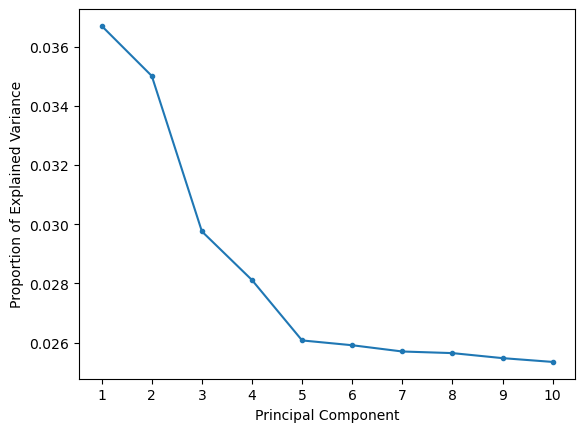

In [12]:
# View PCA explained variance ratio
plt.style.use('default')
plt.plot(range(1, 11), pca.explained_variance_ratio_[:10], marker = '.')
plt.xticks(ticks = range(1, 11))
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance')

### Train-Test split
'Train.csv' dataset will be subdivided into:
* Train,
* Test

$R^2$ will be used as the prefered metric for this regression problem. 

'Train.csv' will be predicted if $R^2$ value is satisfactory. 

In [13]:
seed = 7
test_size = 0.2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train,y_train,test_size=test_size, random_state=seed)

### LinearRegression predictions

In [18]:
tiempoInicio = time.time()

regresor = LinearRegression()
regresor.fit(X_train2, y_train2)

tiempoTranscurrido = time.time() - tiempoInicio
print(f'{tiempoTranscurrido:.2f} transcurridos.')

print('Training accuracy:', regresor.score(X_test2, y_test2))

4.79 transcurridos.
Training accuracy: 0.5730959742606438


### RandomForest predictions

Subset training

In [16]:
tiempoInicio = time.time()

regresor = RandomForestRegressor(bootstrap=True, n_estimators=25,n_jobs=20)
regresor.fit(X_train2, y_train2)

tiempoTranscurrido = time.time() - tiempoInicio
print(f'{tiempoTranscurrido:.2f} transcurridos.')

print('Training R2:', regresor.score(X_test2, y_test2))

153.50 transcurridos.
Training R2: 0.8850939773794873


Full dataset training.

In [14]:
regresor = RandomForestRegressor(bootstrap=True, n_estimators=25,n_jobs=20)
regresor.fit(X_train, y_train)

y_pred = regresor.predict(X_test)
predSave = dataTest.loc[:,['id']]
yPredDf = pd.DataFrame(y_pred,columns=['sales'])
predSave['sales'] = yPredDf.loc[:,'sales']
predSave.index = predSave.loc[:,'id']
predSave.drop(columns=['id'],inplace=True)
predSave.to_csv('data/prediccions_rf4.csv')

### SVM Predictions

Subset training

In [19]:
tiempoInicio = time.time()

regresor = SVR()
regresor.fit(X_train2, y_train2)

tiempoTranscurrido = time.time() - tiempoInicio
print(f'{tiempoTranscurrido:.2f} transcurridos.')

print('Training R2:', regresor.score(X_test2, y_test2))

Full dataset training.

In [ ]:
regresor = SVR()
regresor.fit(X_train, y_train)

y_pred = regresor.predict(X_test)
predSave = dataTest.loc[:,['id']]
yPredDf = pd.DataFrame(y_pred,columns=['sales'])
predSave['sales'] = yPredDf.loc[:,'sales']
predSave.index = predSave.loc[:,'id']
predSave.drop(columns=['id'],inplace=True)
predSave.to_csv('data/prediccions_rf4.csv')

### DecisionTreeRegressor predictions

Subset training

In [24]:
tiempoInicio = time.time()

regresor = DecisionTreeRegressor()
regresor.fit(X_train2, y_train2)

tiempoTranscurrido = time.time() - tiempoInicio
print(f'{tiempoTranscurrido:.2f} transcurridos.')

print('Training R2:', regresor.score(X_test2, y_test2))

29.96 transcurridos.
Training accuracy: 0.8948384889341789


Full dataset training.

In [28]:
regresor = DecisionTreeRegressor()
regresor.fit(X_train, y_train)

y_pred = regresor.predict(X_test)
predSave = dataTest.loc[:,['id']]
yPredDf = pd.DataFrame(y_pred,columns=['sales'])
predSave['sales'] = yPredDf.loc[:,'sales']
predSave.index = predSave.loc[:,'id']
predSave.drop(columns=['id'],inplace=True)
predSave.to_csv('data/prediccions_decision_tree.csv')

## XGBRegressor predictions

Subset training

In [15]:
tiempoInicio = time.time()

regresor = XGBRegressor(n_estimators=400, max_depth=12, eta=0.1, subsample=0.7, colsample_bytree=0.8)
#regresor = XGBRegressor(learning_rate=1,)
regresor.fit(X_train2, y_train2)

tiempoTranscurrido = time.time() - tiempoInicio
print(f'{tiempoTranscurrido:.2f} transcurridos.')

print('Training accuracy:', regresor.score(X_test2, y_test2))

557.41 transcurridos.
Training accuracy: 0.9549587637309929


Full dataset training.

In [16]:
#regresor = XGBRegressor(n_estimators=400, max_depth=12, eta=0.1, subsample=0.7, colsample_bytree=0.8)
regresor.fit(X_train, y_train)

y_pred = regresor.predict(X_test)
predSave = dataTest.loc[:,['id']]
yPredDf = pd.DataFrame(y_pred,columns=['sales'])
predSave['sales'] = yPredDf.loc[:,'sales']
predSave.index = predSave.loc[:,'id']
predSave.drop(columns=['id'],inplace=True)
predSave.to_csv('data/prediccions_xgboost2.csv')

Best score was aquired using RandomForest:

* $R^2 \approx 0.94 $ 
* $Kaggle Score = 0.49955$ 
* Kaggle Position was 218 of 1080